## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust

In [2]:
sns.set_style('darkgrid')

In [3]:
# obtain data from unphased callset - only needed for variant annotations
callset_pass = phase1_ar31.callset_pass
pos_pass = allel.SortedIndex(callset_pass['2L/variants/POS'])
ann_pass = callset_pass['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

In [4]:
# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])

In [5]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [6]:
region_vgsc = SeqFeature('2L', 2358158, 2431617)
region_vgsc

<SeqFeature 2L:2358158-2431617>

In [7]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 5000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

<SortedIndex shape=(281831,) dtype=int32>
[44688, 44691, 44732, 44736, 44756, ..., 4996563, 4996572, 4996573, 4996579, 4996582]

In [8]:
# locate the intersection with unphased callset - needed to tie in annotations
loc1, _ = pos_pass.locate_intersection(pos_phased_region)
np.count_nonzero(loc1)

281831

In [9]:
ann_phased_region = ann_pass[loc1]
ann_phased_region

array([(b'intergenic_region', b'.'), (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), ..., (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), (b'intergenic_region', b'.')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')])

In [10]:
# exclude cross parents
haps_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16].compute()
haps_region

<HaplotypeArray shape=(281831, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [11]:
# perform allele count - needed to locate singletons
ac_phased_region = haps_region.count_alleles(max_allele=1)

In [12]:
%%cython


# cython: boundscheck=False
# cython: wraparound=False


cimport numpy as np
import numpy as np


def reconstruct_ancestral_haplotype_flank(np.int8_t[:, :] haps_flank, np.uint8_t[:] loc_ehh):
   
    cdef:
        Py_ssize_t n_variants, n_haplotypes, i, j
        np.uint8_t[:] clust_anc
        np.int32_t[:] ac
        np.int8_t[:] hap_anc
        np.int8_t allele
    
    # setup intermediates and outputs
    n_variants, n_haplotypes = haps_flank.shape[:2]
    assert n_variants == loc_ehh.shape[0]
    clust_anc = np.ones(n_haplotypes, dtype='u1')
    ac = np.zeros(2, dtype='i4')
    hap_anc = np.full(n_variants, dtype='i1', fill_value=-1)
    
    # iterate over variants
    for i in range(n_variants):
                
        # count alleles within the ancestral cluster
        ac[:] = 0  # reset
        for j in range(n_haplotypes):
            if clust_anc[j]:
                allele = haps_flank[i, j]
                if allele >= 0:
                    ac[allele] += 1
                    
        # find ancestral allele
        if ac[0] >= ac[1]:
            # if tie, assume reference
            anc_allele = 0
            der_allele = 1
        else:
            anc_allele = 1
            der_allele = 0
        # patch into ancestral haplotype
        hap_anc[i] = anc_allele

        # detect bifurcation
        if loc_ehh[i] and ac[0] > 0 and ac[1] > 0:

            # split cluster
            for j in range(n_haplotypes):
                if clust_anc[j]:
                    if haps_flank[i, j] == der_allele:
                        clust_anc[j] = 0

#             # bail out if only one haplotype left
#             if ac[anc_allele] < 2:
#                 print('no more EHH at index %s' % i)
#                 break
            
    return hap_anc


In [13]:
def reconstruct_ancestral_haplotype(haps, pos, core_pos, loc_ehh):
    """Reconstruct the putative ancestral haplotype from the flank of a selective sweep, 
    using the majority rule."""

    assert haps.shape[0] == pos.shape[0] == loc_ehh.shape[0]
    
    # split flanks
    idx_core = pos.locate_key(core_pos)
    haps_right = haps[idx_core:]
    haps_left = haps[:idx_core][::-1]
    loc_ehh_right = loc_ehh[idx_core:]
    loc_ehh_left = loc_ehh[:idx_core][::-1]
    
    # reconstruct ancestral haplotype for each flank
    hap_right_anc = reconstruct_ancestral_haplotype_flank(np.asarray(haps_right, dtype='i1'), np.asarray(loc_ehh_right, dtype='u1'))
    hap_left_anc = reconstruct_ancestral_haplotype_flank(np.asarray(haps_left, dtype='i1'), np.asarray(loc_ehh_left, dtype='u1'))
    
    # join back together
    hap_anc = np.concatenate([hap_left_anc[::-1], hap_right_anc])
    
    return hap_anc


### make vgsc_haplogroups dictionary

In [14]:
#grab the npy array made in ag1000g paper 1 vgsc notebook
p1clus = np.load('../data/vgsc_cluster_membership.npy')

In [15]:
#make this into a dictionary

p1list = [a.decode("utf-8") for a in p1clus]
p1list = np.asarray(p1list)
np.unique(p1list)[1:], len(p1list)

(array(['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5'], 
       dtype='<U2'), 1530)

In [16]:
nlist = list(np.unique(p1list)[1:])
nlist

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5']

In [17]:
vgsc_haplogroups = {n: np.nonzero(p1list == n)[0] for n in nlist}

In [18]:
vgsc_haplogroups['S2']

array([ 849,  927,  944,  983, 1114, 1118, 1201, 1221, 1357, 1358, 1360,
       1361, 1362, 1364, 1366, 1369, 1370, 1371, 1373, 1376, 1377, 1378,
       1380, 1382, 1383, 1384, 1386, 1388, 1389, 1390, 1393, 1395, 1396,
       1398, 1400, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1411, 1412,
       1413, 1414, 1416, 1417, 1418, 1420, 1422, 1424, 1426, 1429, 1431,
       1432, 1434, 1435, 1436, 1439, 1440, 1441, 1442, 1443, 1444, 1445,
       1446, 1447, 1448, 1449, 1451, 1452, 1454, 1455, 1457, 1458, 1459,
       1463, 1465])

In [19]:
core_pos = pos_kdr_f

is_accessible = phase1_ar3.accessibility['2L/is_accessible'][:]

sorted(vgsc_haplogroups.keys())

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5']

In [20]:
def get_haps(hg):
    return haps_region.take(sorted(vgsc_haplogroups[hg]), axis=1)

In [21]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                    (ann_phased_region['Annotation'] == b'intron_variant') |
                    (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'synonymous_variant') |
                    (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(268259, (281831,))

In [22]:
# locate low frequency variants - will exclude from EHH analysis
loc_hf = ac_phased_region.min(axis=1) > 1
print(np.count_nonzero(loc_hf))

# these are the variants to use for EHH
loc_ehh = loc_type_neutral & loc_hf
print(np.count_nonzero(loc_ehh), loc_ehh.shape)

haps_anc = dict()
for hg in sorted(vgsc_haplogroups):
    haps_anc[hg] = reconstruct_ancestral_haplotype(get_haps(hg), pos_phased_region, pos_kdr_f, loc_ehh)

193032
185122 (281831,)


In [23]:
# # locate low frequency variants - will exclude from EHH analysis
# loc_hf = ac_phased_region.min(axis=1) > 15
# print(np.count_nonzero(loc_hf))

# # these are the variants to use for EHH
# loc_ehh = loc_type_neutral & loc_hf
# print(np.count_nonzero(loc_ehh), loc_ehh.shape)

# haps_anc = dict()
# for hg in sorted(vgsc_haplogroups):
#     print(hg)
#     haps_anc[hg] = reconstruct_ancestral_haplotype(get_haps(hg), pos_phased_region, pos_kdr_f, loc_ehh)

In [24]:
# This function is available in scikit-allel but does not support the step parameter.
# Modify here instead as work-around for now.


def equally_accessible_windows(is_accessible, size, step=None):
    """Create windows each containing the same number of accessible bases.

    Parameters
    ----------
    is_accessible : array_like, bool, shape (n_bases,)
        Array defining accessible status of all bases on a contig/chromosome.
    size : int
        Window size (number of accessible bases).
    step : int, optional
        The distance between start positions of windows. If not given,
        defaults to the window size, i.e., non-overlapping windows.

    Returns
    -------
    windows : ndarray, int, shape (n_windows, 2)
        Window start/stop positions (1-based).

    """
    pos_accessible, = np.nonzero(is_accessible)
    pos_accessible += 1  # convert to 1-based coordinates
    windows = allel.moving_statistic(pos_accessible, lambda v: [v[0], v[-1]], size=size, step=step)
    return windows


In [25]:
def plot_divergence(ref_hg, haps, xlim=(0, 5000000), ylim=(-0.0005, 0.013), window_size=20000, window_step=1000,
                    ax=None, color='k', lw=.5, alpha=.2, show_gene=True):
    
    hap_anc = haps_anc[ref_hg]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2), dpi=120)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    windows = equally_accessible_windows(is_accessible, size=window_size, step=window_step)
    # exclude windows where we could not reconstruct the ancestral haplotype
    missing, _, _ = allel.windowed_statistic(pos=pos_phased_region, values=(hap_anc < 0), statistic=np.count_nonzero, windows=windows)
    
    windows = windows[missing == 0]
    x = np.mean(windows, axis=1)
    
    if show_gene:
        ax.axvline(region_vgsc.start, color='k', linestyle=':')
        ax.axvline(region_vgsc.end, color='k', linestyle=':')
        ax.annotate('$Vgsc$', xy=((region_vgsc.end-xlim[0])/(xlim[1]-xlim[0]), 1), xycoords='axes fraction',
                    xytext=(0, 0), textcoords='offset points', fontsize=8, ha='left', va='top')
#         ax.annotate('^', xy=((pos_kdr_f - xlim[0])/(xlim[1] - xlim[0]), 0), xycoords='axes fraction',
#                     xytext=(0, 0), textcoords='offset points', fontsize=8, ha='center', va='top')

    for j in range(haps.shape[1]):
        h = haps[:, j]
        values = h != hap_anc
        d, _, _ = allel.windowed_statistic(pos=pos_phased_region, values=values, statistic=np.count_nonzero, windows=windows)
        ax.plot(x, d/window_size, color=color, lw=lw, alpha=alpha)
        
    xticks = np.arange(0, xlim[1], 500000)
    xticklabels = xticks/1e6
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel('$D_{xy}$')
    ax.set_xlabel('Chromosome 2L position (Mbp)')
    ax.set_title('Divergence from %s ancestral haplotype' % ref_hg, loc='left', ha='left', fontsize=9)
    return ax
    

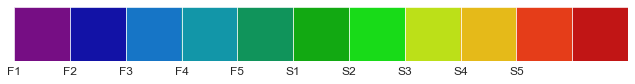

In [26]:
# TODO review colours
hg_palette = sns.color_palette('spectral', n_colors=11, desat=.8)
hg_colors = dict((k, c) for k, c in zip(sorted(vgsc_haplogroups), hg_palette))
sns.palplot(hg_palette)
ax = plt.gca()
ax.set_xticklabels(sorted(vgsc_haplogroups), fontsize=12);

In [27]:
def plot_divergence_multi(ref_hg, comp_hgs, ax=None, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2), dpi=150)

    for i, hg in enumerate(comp_hgs):
        plot_divergence(ref_hg, get_haps(hg), color=hg_colors[hg], ax=ax, show_gene=(i == 0), **kwargs)

    handles = [mpl.patches.Patch(color=hg_colors[hg], label=hg) for hg in comp_hgs]
    ax.legend(bbox_to_anchor=(1, 1), loc='upper right', handles=handles, frameon=True, framealpha=1);


## Combined figure

In [28]:
def megafig(hgs, xlim=(1.5e6, 3.5e6), window_size=20000, window_step=1000):

    nrows = len(hgs)
    ncols = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(9, nrows*1.8), dpi=120, sharex=True, sharey=True, squeeze=False)

    for i, ref_hg in enumerate(hgs):
        ax = axs[i, 0]
        plot_divergence_multi(ref_hg, [ref_hg], xlim=xlim, ax=ax)
        if i < len(hgs) - 1:
            ax.set_xlabel('')
        ax = axs[i, 1]
        plot_divergence_multi(ref_hg, [x for x in hgs if x != ref_hg], xlim=xlim, ax=ax, 
                              window_size=window_size, window_step=window_step)
        ax.set_ylabel('')
        if i < len(hgs) - 1:
            ax.set_xlabel('')

    fig.tight_layout()

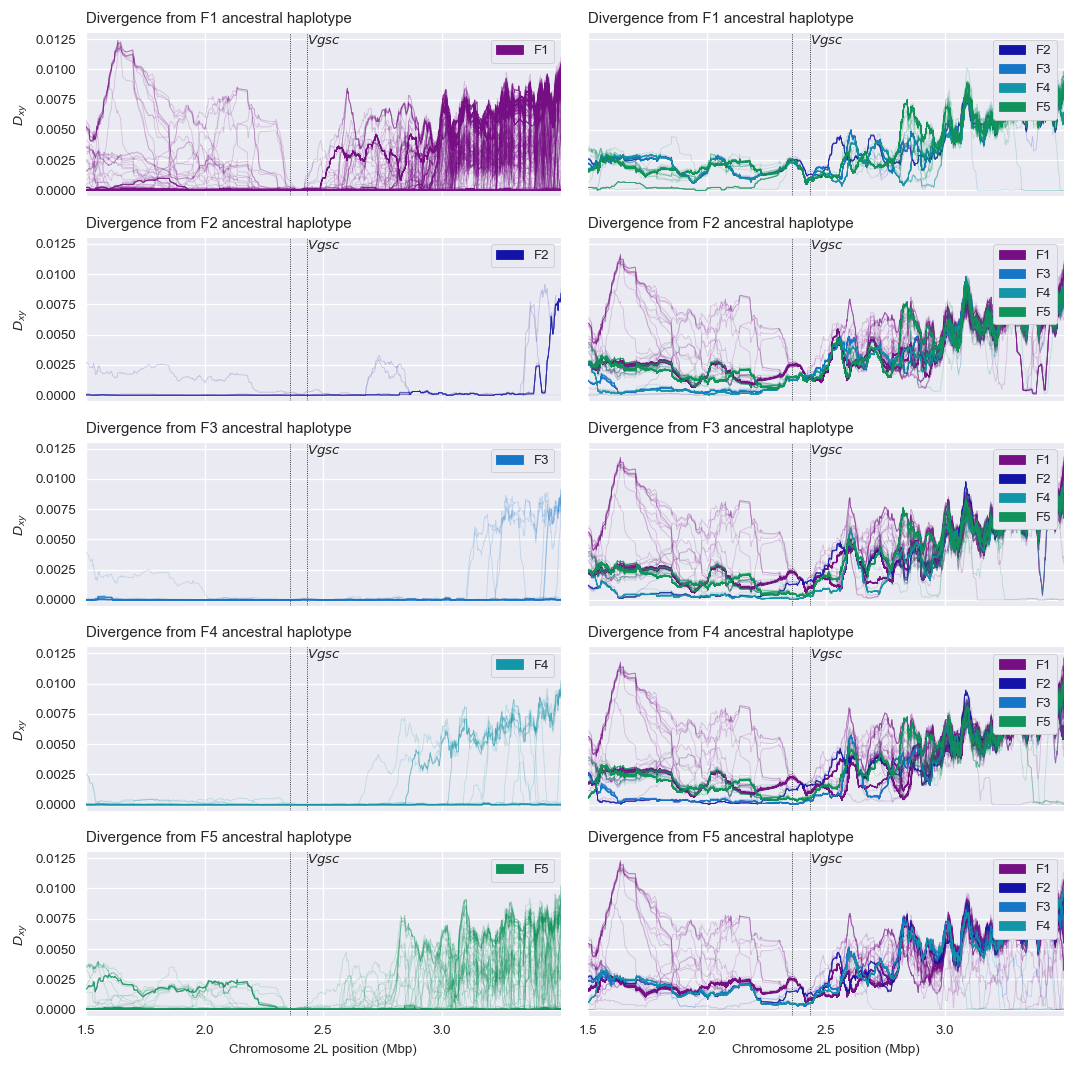

In [29]:
megafig(['F1', 'F2', 'F3', 'F4', 'F5'])

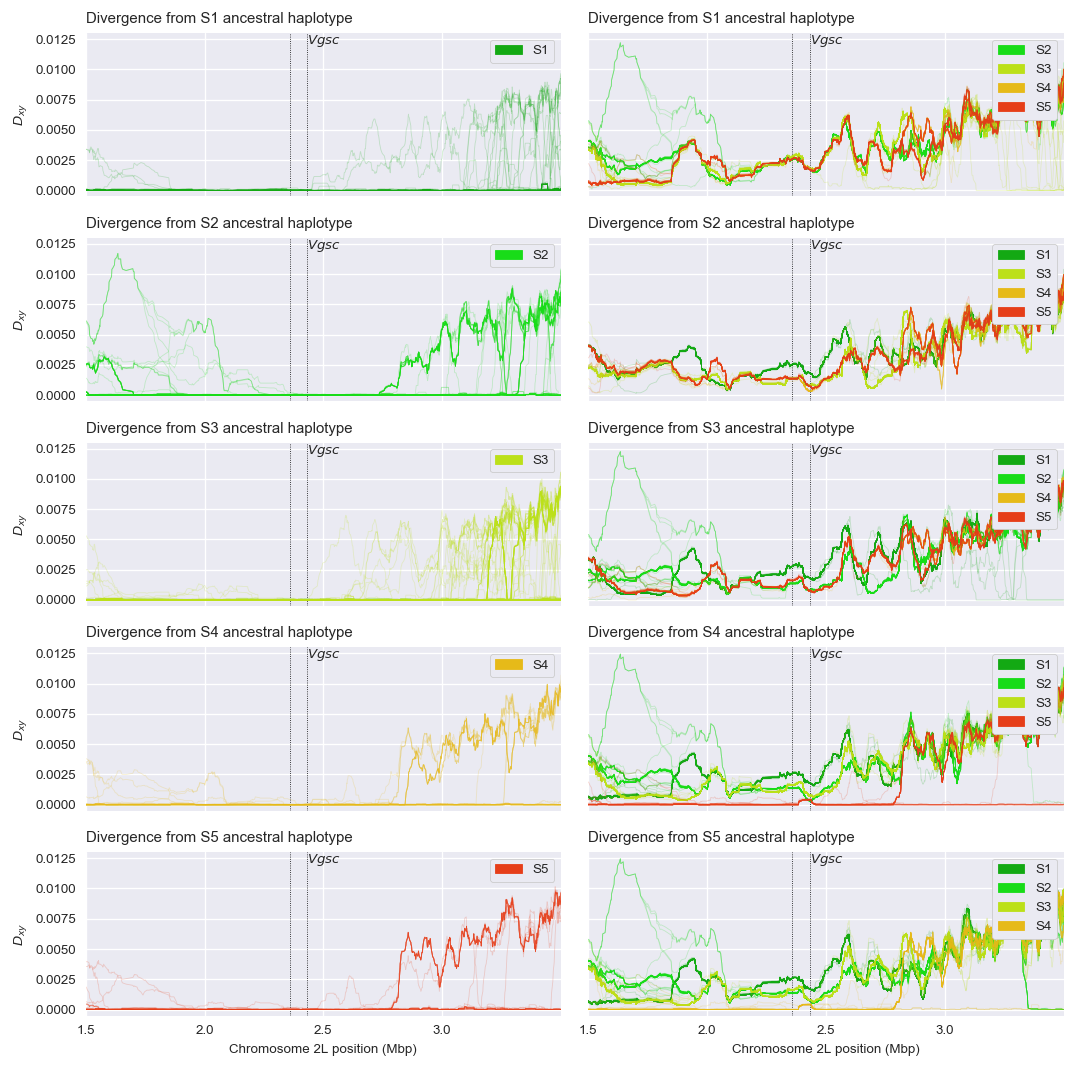

In [30]:
megafig(['S1', 'S2', 'S3', 'S4', 'S5'])

## Detail

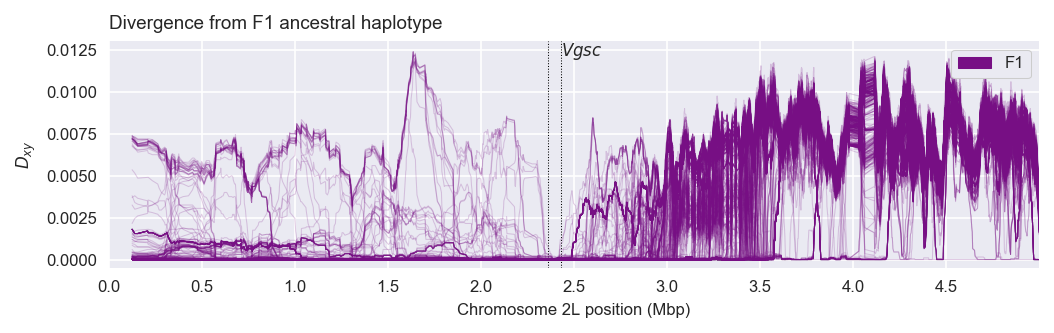

In [31]:
plot_divergence_multi('F1', ['F1'])

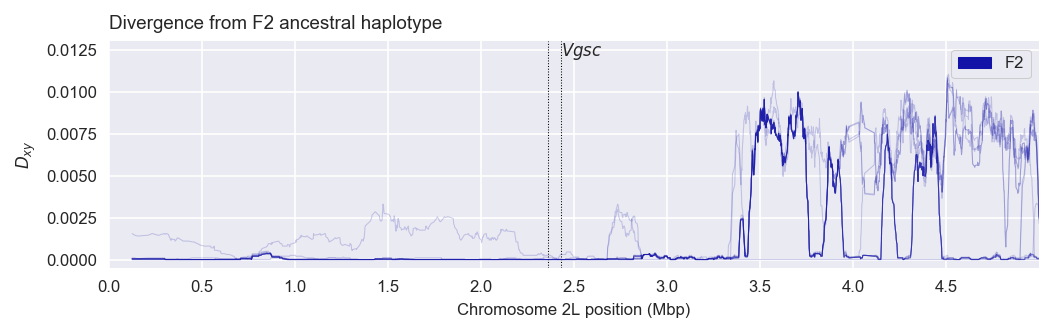

In [32]:
plot_divergence_multi('F2', ['F2'])

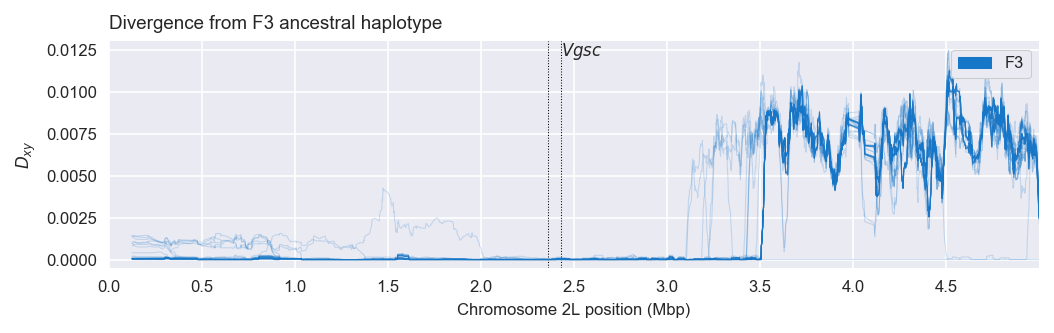

In [33]:
plot_divergence_multi('F3', ['F3'])

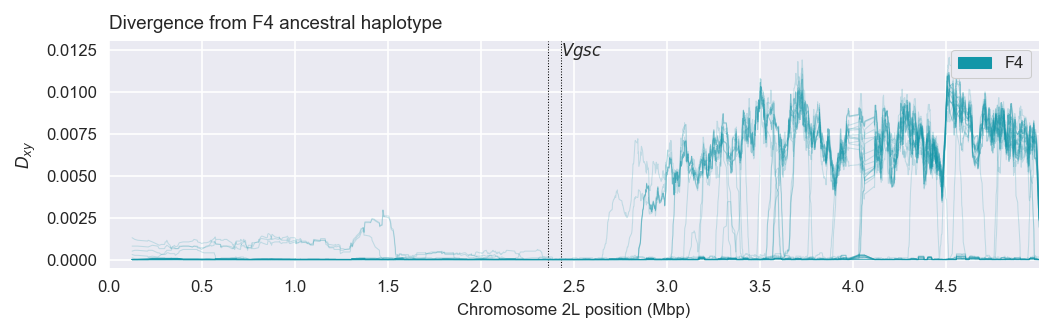

In [34]:
plot_divergence_multi('F4', ['F4'])

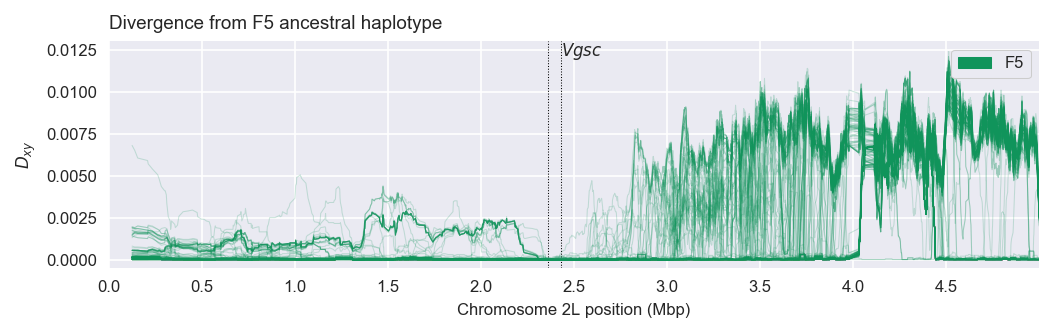

In [35]:
plot_divergence_multi('F5', ['F5'])

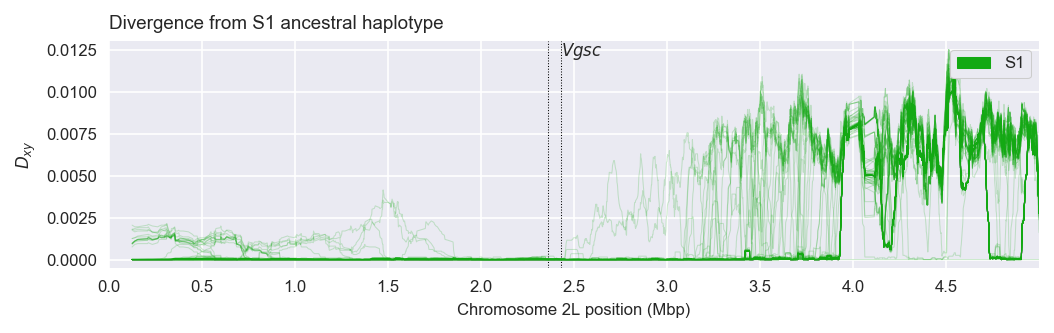

In [36]:
plot_divergence_multi('S1', ['S1'])

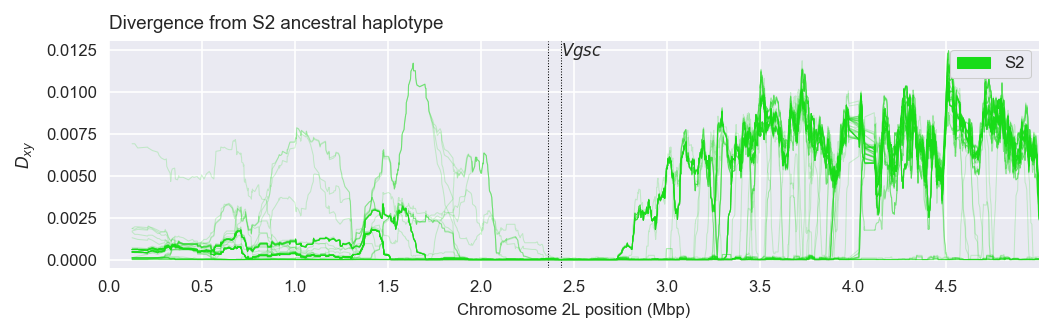

In [37]:
plot_divergence_multi('S2', ['S2'])

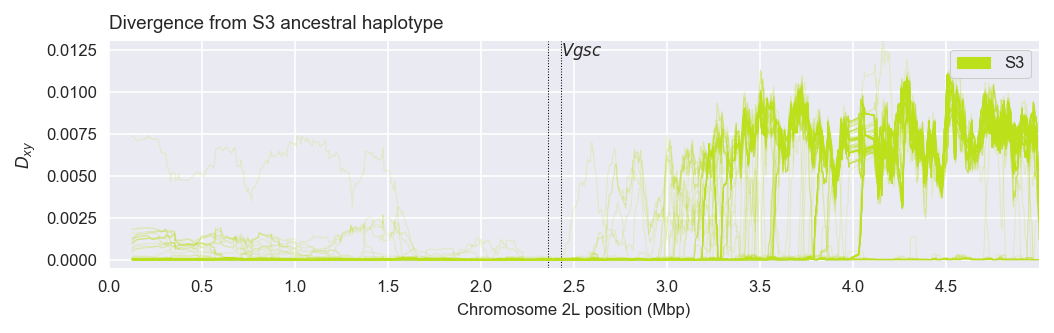

In [38]:
plot_divergence_multi('S3', ['S3'])

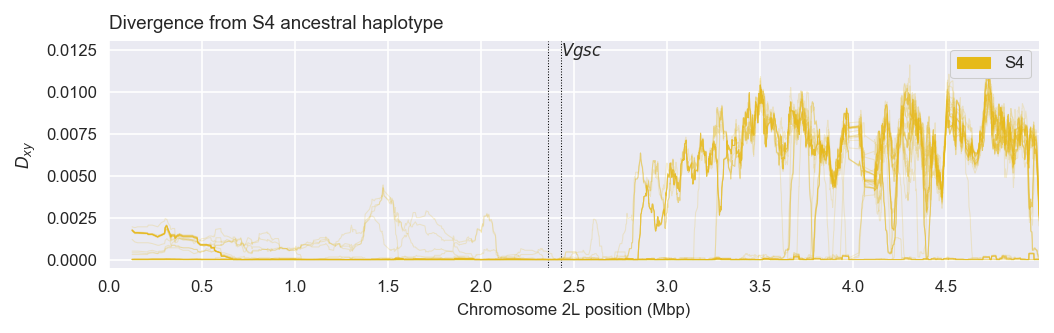

In [39]:
plot_divergence_multi('S4', ['S4'])

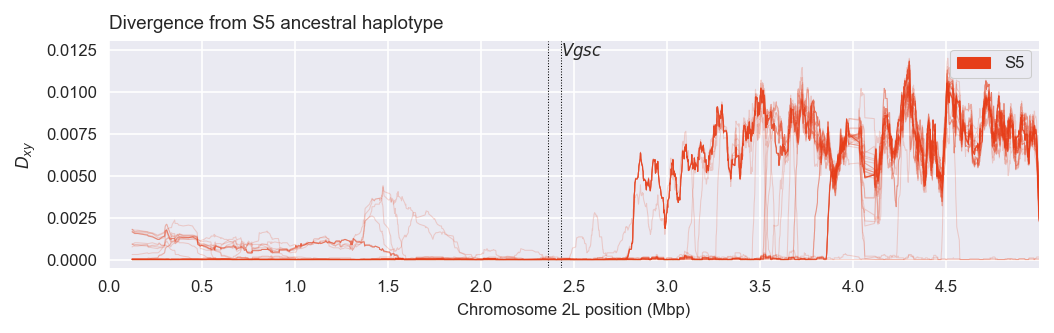

In [40]:
plot_divergence_multi('S5', ['S5'])

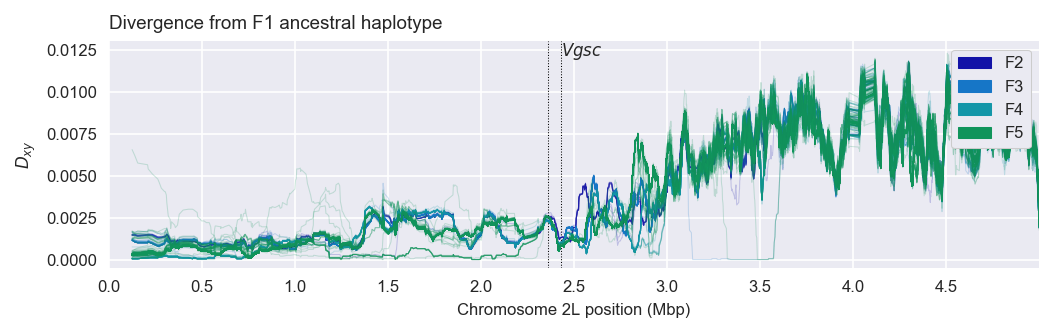

In [41]:
plot_divergence_multi('F1', ['F2', 'F3', 'F4', 'F5'])

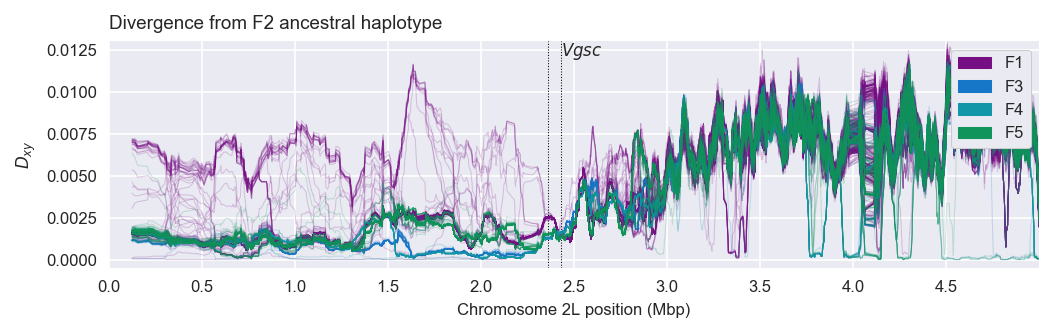

In [42]:
plot_divergence_multi('F2', ['F1', 'F3', 'F4', 'F5'])

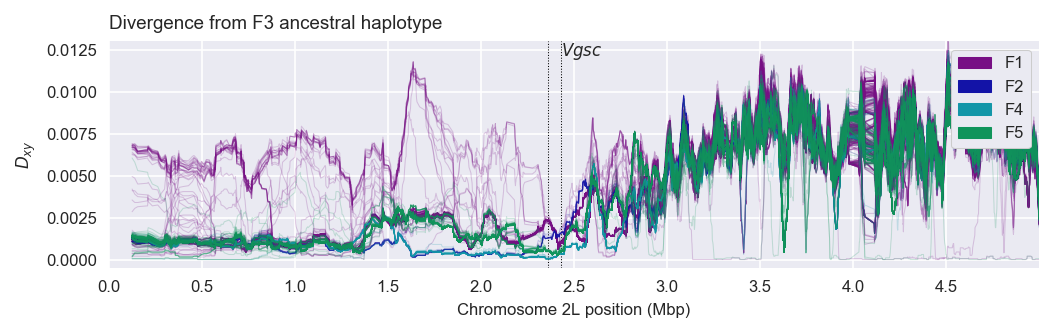

In [43]:
plot_divergence_multi('F3', ['F1', 'F2', 'F4', 'F5'])

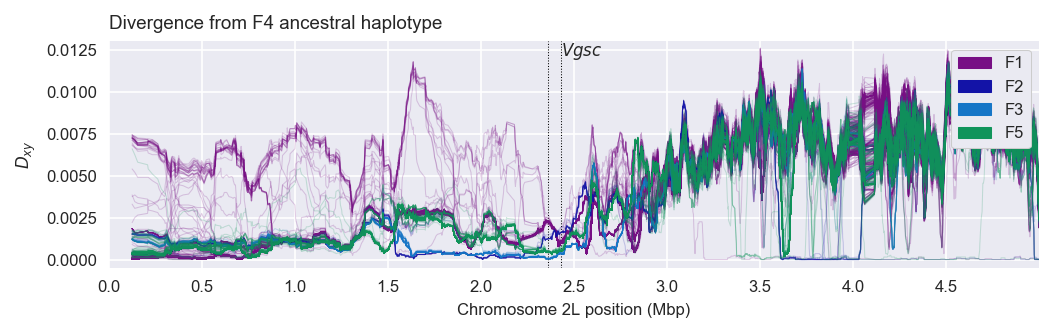

In [44]:
plot_divergence_multi('F4', ['F1', 'F2', 'F3', 'F5'])

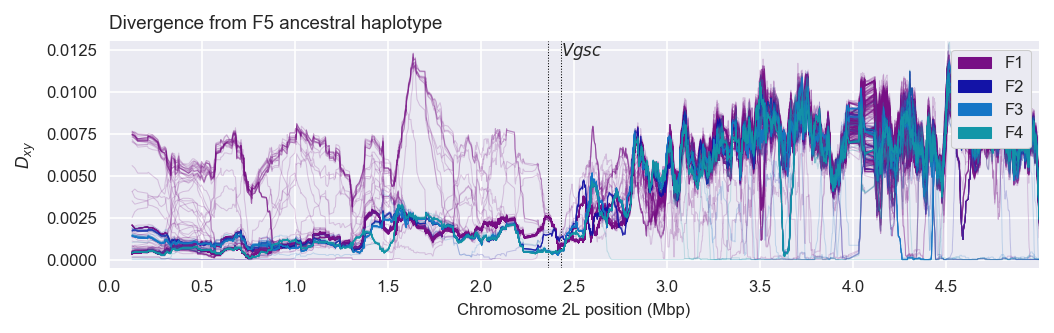

In [45]:
plot_divergence_multi('F5', ['F1', 'F2', 'F3', 'F4'])

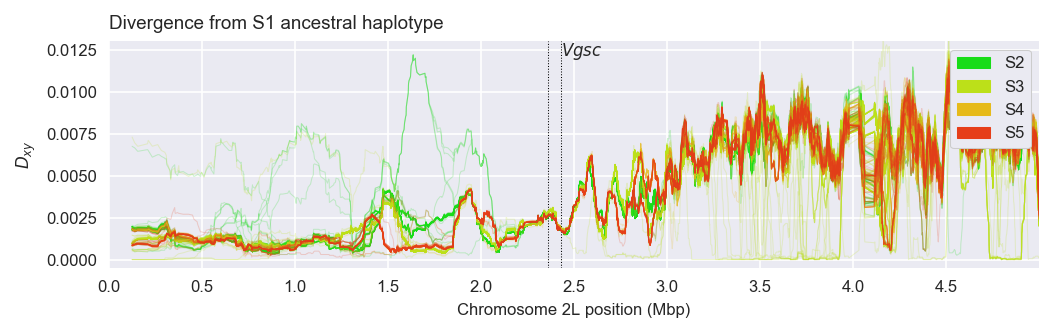

In [46]:
plot_divergence_multi(
    'S1', 
    [
        # 'S1', 
        'S2', 
        'S3', 
        'S4',
        'S5'
    ]
)

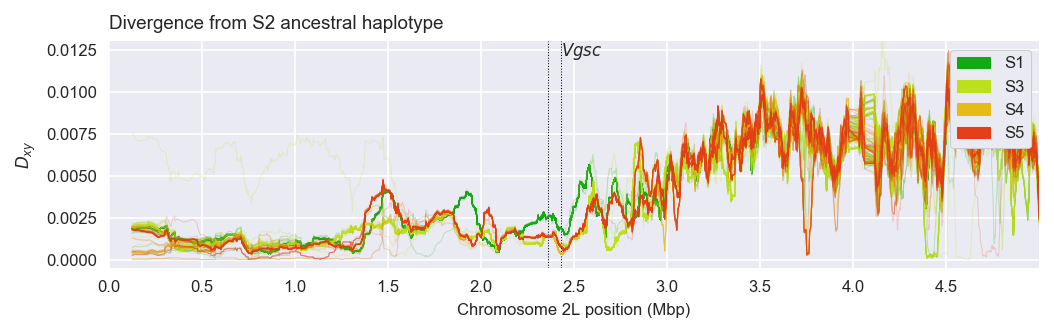

In [47]:
plot_divergence_multi(
    'S2', 
    [
        'S1', 
        # 'S2', 
        'S3', 
        'S4',
        'S5'
    ]
)

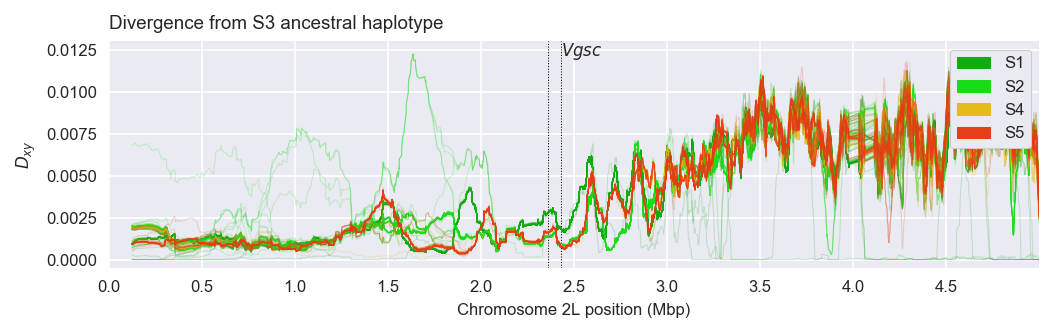

In [48]:
plot_divergence_multi(
    'S3', 
    [
        'S1', 
        'S2', 
        # 'S3', 
        'S4',
        'S5'
    ]
)

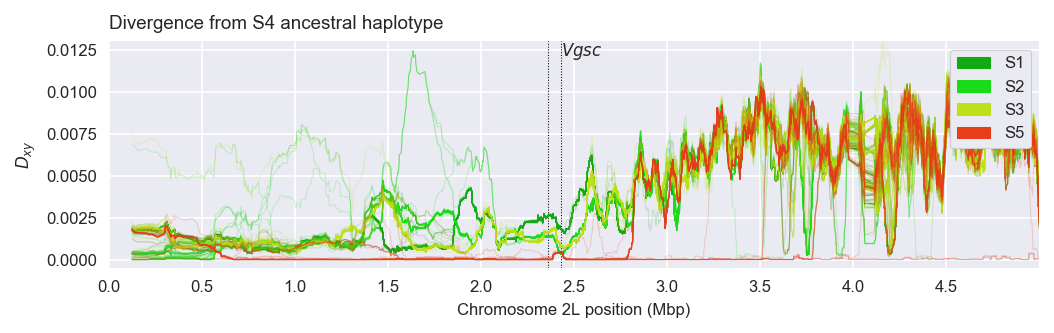

In [49]:
plot_divergence_multi(
    'S4', 
    [
        'S1', 
        'S2', 
        'S3', 
        #'S4',
        'S5'
    ]
)

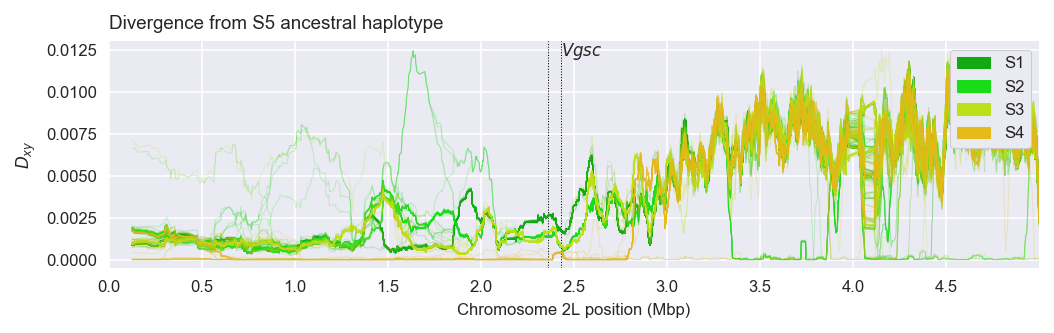

In [50]:
plot_divergence_multi(
    'S5', 
    [
        'S1', 
        'S2', 
        'S3', 
        'S4'
        #'S5'
    ]
)